In [1]:
import torch
import rasterio
import importlib
import matplotlib.pyplot as plt
from simvp import SimVP
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [2]:
import torch
import torch.nn as nn
print(torch.__version__)
print(torch.version.cuda)


2.3.0
12.1


In [3]:
import torch
print(torch.cuda.is_available())  # Should print True
print(torch.cuda.get_device_name(0))  # Should print the name of your GPU


True
NVIDIA GeForce RTX 4060 Laptop GPU


In [4]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

import torch
x = torch.rand(10, 10, device='cuda')
y = torch.rand(10, 10, device='cuda')
z = x + y  # Test simple operation again
print(z)


tensor([[1.7293, 1.1445, 1.3216, 0.6313, 0.7504, 0.8764, 1.0475, 0.6600, 1.4891,
         0.7068],
        [1.5251, 0.9318, 1.5727, 0.7864, 1.3360, 1.0593, 0.8898, 1.5354, 0.8500,
         0.6279],
        [1.0157, 1.2348, 1.4012, 1.3655, 1.0466, 1.0264, 1.3161, 1.0259, 1.1291,
         0.7111],
        [0.5591, 1.2522, 1.0194, 0.2314, 1.2227, 1.7283, 0.3896, 1.4781, 1.3382,
         1.2579],
        [0.7527, 0.9189, 0.3979, 0.8999, 1.1932, 1.3009, 0.5162, 0.9523, 0.9258,
         1.0982],
        [1.6665, 1.6269, 0.9193, 0.2940, 1.3979, 0.7873, 1.4428, 1.3637, 0.4720,
         1.0028],
        [0.4512, 0.9367, 0.6757, 0.5456, 0.5335, 1.7313, 0.8111, 0.4260, 0.7768,
         0.7266],
        [1.2050, 1.2445, 1.6626, 1.0595, 1.4475, 1.1388, 1.2202, 1.2116, 1.1308,
         0.5556],
        [0.9220, 1.1408, 0.5996, 1.7010, 1.4391, 1.2280, 1.4926, 1.4520, 1.1635,
         0.7543],
        [1.7476, 0.6692, 0.7082, 1.0977, 1.4998, 1.3041, 1.0717, 1.3774, 0.9791,
         0.8861]], device='c

In [5]:
# root_dir = r'D:\Workspace\Projects\qpn-simvp\data\DATA_SV\Precipitation\Radar\2019\10\01\Radar_20191001000000.tif'
# root_dir2 = r'D:\Workspace\Projects\qpn-simvp\data\DATA_SV\Precipitation\Radar\2019\10\01\Radar_20191001010000.tif'
# root_dir3 = r'D:\Workspace\Projects\qpn-simvp\data\DATA_SV\Precipitation\Radar\2019\10\01\Radar_20191001020000.tif'
# img = rasterio.open(root_dir)
# data = img.read(1)  # Read the only band
# plt.figure(figsize=(10, 10))
# plt.imshow(data)
# img2 = rasterio.open(root_dir2)
# data2 = img2.read(1)  # Read the only band
# plt.figure(figsize=(10, 10))
# plt.imshow(data2)
# img3 = rasterio.open(root_dir3)
# data3 = img.read(1)  # Read the only band
# plt.figure(figsize=(10, 10))
# plt.imshow(data3)

def init_weights(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

def hook(module, input, output):
    if torch.isnan(output).any():
        print(f"NaNs in {module}")

In [6]:
class RadarTIFFDataset(Dataset):
    def __init__(self, file_paths):
        self.file_paths = file_paths
        self.transform = transforms.Compose([
            transforms.ToTensor(),  # Converts numpy array to torch tensor and scales to [0,1]
            transforms.Lambda(lambda x: x.float()),  # Ensure the tensor is float32
            transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize around the dataset mean and std dev if known
        ])

    def __len__(self):
        return len(self.file_paths) - 2  # As we need 3 images to create a single data point

    def __getitem__(self, idx):
        # Use rasterio to open and read three consecutive files
        with rasterio.open(self.file_paths[idx]) as img1:
            x1 = img1.read(1).astype(float)  # Ensure data is float before transformation
        
        with rasterio.open(self.file_paths[idx + 1]) as img2:
            x2 = img2.read(1).astype(float)
        
        with rasterio.open(self.file_paths[idx + 2]) as img3:
            y = img3.read(1).astype(float)

        # Apply transformations
        x1 = self.transform(x1)
        x2 = self.transform(x2)
        y = self.transform(y)

        # Stack x1 and x2 along a new 'time' dimension
        x = torch.stack([x1, x2], dim=0)
        return x, y

# Usage Example
file_paths = [
    r'D:\Workspace\Projects\qpn-simvp\data\DATA_SV\Precipitation\Radar\2019\10\01\Radar_20191001000000.tif',
    r'D:\Workspace\Projects\qpn-simvp\data\DATA_SV\Precipitation\Radar\2019\10\01\Radar_20191001010000.tif',
    r'D:\Workspace\Projects\qpn-simvp\data\DATA_SV\Precipitation\Radar\2019\10\01\Radar_20191001020000.tif'
]

dataset = RadarTIFFDataset(file_paths)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# Example to visualize one batch of data
for x, y in dataloader:
    print("Input shape:", x.shape)  # Expect [batch_size, 2, height, width]
    print("Output shape:", y.shape)  # Expect [batch_size, 1, height, width]
    break


Input shape: torch.Size([1, 2, 1, 90, 250])
Output shape: torch.Size([1, 1, 90, 250])


In [7]:
# Assuming the necessary dimensions for hid and enc1 based on your network architecture
from simvp import Decoder
dummy_hid = torch.randn(1, 256, 60, 160)  # Adjust the size according to your Decoder's input requirements
dummy_enc1 = torch.randn(1, 256, 60, 160)  # Same here, assuming you use enc1

# Instantiate Decoder
decoder = Decoder(C_hid=256, C_out=1, N_S=5)  # Use actual values from your implementation
print("Decoder initialized successfully")
# Test the Decoder
output = decoder(dummy_hid, dummy_enc1)


Decoder initialized successfully
Shape after each Decoder step: torch.Size([1, 256, 240, 640])
Shape after resizing hid: torch.Size([1, 256, 90, 250])
Shape after resizing enc1: torch.Size([1, 256, 90, 250])
Shape before final readout: torch.Size([1, 256, 90, 250])


In [8]:
save_dir = r'D:\Workspace\Projects\qpn-simvp\simvp\pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimVP(shape_in=(2, 3, 128, 128)).to(device)  # Adjust shape_in according to your data shape
# model.apply(init_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.MSELoss()
num_epochs = 10
# Training loop
for epoch in range(num_epochs):
    for x, y_true in dataloader:
        x = x.to(device)  # Move inputs to the appropriate device
        y_true = y_true.to(device)  # Move targets to the appropriate device

        optimizer.zero_grad()
        y_pred = model(x)  # Generate predictions

        # Print shapes to debug and verify dimensions
        print("y_pred shape:", y_pred.shape)
        print("y_true initial shape:", y_true.shape)

        # Adjust y_true to match y_pred's dimensions if necessary
        if y_pred.size() != y_true.size():
            y_true = y_true.repeat(1, 2, 1, 1, 1)  # Adjust the repeat pattern to match y_pred's shape

        print("y_true adjusted shape:", y_true.shape)

        loss = criterion(y_pred, y_true)  # Compute loss
        loss.backward()  # Backpropagation

        # Check for NaN gradients and apply gradient clipping
        for name, param in model.named_parameters():
            if param.grad is not None:
                if torch.any(torch.isnan(param.grad)):
                    print(name, "has NaN gradients")
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()  # Update model parameters

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")
    model_save_path = os.path.join(save_dir, f'model_epoch_{epoch}.pth')
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved for epoch {epoch} at {model_save_path}")

torch.Size([1, 2, 1, 90, 250])
Shape after each Decoder step: torch.Size([2, 16, 92, 252])
Shape after resizing hid: torch.Size([2, 16, 90, 250])
Shape after resizing enc1: torch.Size([2, 16, 90, 250])
Shape before final readout: torch.Size([2, 16, 90, 250])
y_pred shape: torch.Size([1, 2, 1, 90, 250])
y_true initial shape: torch.Size([1, 1, 90, 250])
y_true adjusted shape: torch.Size([1, 2, 1, 90, 250])


d:\anaconda3\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


enc.enc.0.conv.conv.weight has NaN gradients
enc.enc.0.conv.conv.bias has NaN gradients
enc.enc.0.conv.norm.weight has NaN gradients
enc.enc.0.conv.norm.bias has NaN gradients
enc.enc.1.conv.conv.weight has NaN gradients
enc.enc.1.conv.conv.bias has NaN gradients
enc.enc.1.conv.norm.weight has NaN gradients
enc.enc.1.conv.norm.bias has NaN gradients
enc.enc.2.conv.conv.weight has NaN gradients
enc.enc.2.conv.conv.bias has NaN gradients
enc.enc.2.conv.norm.weight has NaN gradients
enc.enc.2.conv.norm.bias has NaN gradients
enc.enc.3.conv.conv.weight has NaN gradients
enc.enc.3.conv.conv.bias has NaN gradients
enc.enc.3.conv.norm.weight has NaN gradients
enc.enc.3.conv.norm.bias has NaN gradients
hid.enc.0.conv1.weight has NaN gradients
hid.enc.0.conv1.bias has NaN gradients
hid.enc.0.layers.0.conv.weight has NaN gradients
hid.enc.0.layers.0.conv.bias has NaN gradients
hid.enc.0.layers.0.norm.weight has NaN gradients
hid.enc.0.layers.0.norm.bias has NaN gradients
hid.enc.0.layers.1.conv.

torch.Size([1, 2, 1, 90, 250])
Shape after each Decoder step: torch.Size([2, 16, 92, 252])
Shape after resizing hid: torch.Size([2, 16, 90, 250])
Shape after resizing enc1: torch.Size([2, 16, 90, 250])
Shape before final readout: torch.Size([2, 16, 90, 250])


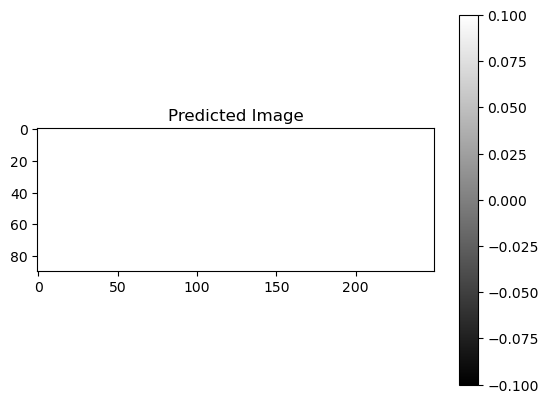

In [18]:
import rasterio
import numpy as np
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Path to your input TIFF file
input_file_path = 'D:\\Workspace\\Projects\\qpn-simvp\\data\\DATA_SV\\Precipitation\\Radar\\2019\\10\\01\\Radar_20191001000000.tif'

# Load the data using rasterio
with rasterio.open(input_file_path) as src:
    input_data = src.read(1)  # Read the first band

# Convert the data to float and normalize
input_data = input_data.astype(np.float32)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Apply transformation
input_tensor = transform(input_data)
input_tensor = torch.stack([input_tensor, input_tensor], dim=0)  # Simulating a sequence
input_tensor = input_tensor.unsqueeze(0).to(device)  # Adding batch dimension

# Load the model
model = SimVP(shape_in=(2, 1, 90, 250)).to(device)
model.load_state_dict(torch.load('D:\\Workspace\\Projects\\qpn-simvp\\simvp\\pth\\model_epoch_9.pth'))
model.eval()

# Predict and visualize
with torch.no_grad():
    prediction = model(input_tensor)
    predicted_image = prediction.squeeze().cpu().numpy()  # Removing batch dimension
    predicted_frame = predicted_image[0]  # Selecting the first frame
    plt.imshow(predicted_frame, cmap='gray')
    plt.colorbar()
    plt.title("Predicted Image")
    plt.show()
